In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime as dt
from datetime import date, timedelta
from functools import reduce
import math
import seaborn as sns
import matplotlib.pyplot as plt


warnings.simplefilter("ignore")

# set plot style
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14.0, 5.0)
plt.rcParams['figure.dpi'] = 400

In [2]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn.metrics as metrics

In [3]:
def getDates():
    base = date(2020, 1, 23)
    delta = (date.today()-timedelta(1)) - base
    return [base + timedelta(days=x) for x in range(delta.days+1)]

def graphData(df, name):
    country = df[df["Country"] == name].groupby("Country").sum()
    graph = country.iloc[0,2:len(df)]
    return graph, graph.index 

def getCleanData():
    pbar = ProgressBar()
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-22-2020.csv')
    df.rename(columns={'Province/State':'Province_State', 'Country/Region':'Country_Region', 'Latitude':'Lat', 'Longitude':'Long'}, inplace=True)
    for date in pbar(date_list):
        url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv'.format(date.strftime("%m-%d-%Y"))
        df_temp = pd.read_csv(url)
        df_temp.rename(columns={'Province/State':'Province_State', 'Country/Region':'Country_Region', 'Latitude':'Lat', 'Longitude':'Long', 'Long_':'Long'}, inplace=True)
        df = df.append(df_temp)
    return df

def readRenameSumTotal(url):
    df = pd.read_csv(url)
    df.rename(columns={"Province/State":"Prov", "Country/Region":"Country"}, inplace=True)
    cases_sum = df.sum()[-1]
    df.loc["Total"] = df.sum()
    df.iloc[-1,1] = "Worldwide"
    return df, cases_sum

def getDatewiseOverall(dataframes):
    labels = ['Confirmed', 'Deaths', 'Recovered']
    column_names = ["Date", "Datetime", "Confirmed", "Deaths", "Recovered"]
    dfs = []
    for i in range(len(dataframes)):
        series = dataframes[i].drop(['Lat', 'Long', 'Country', 'Prov'], axis=1).iloc[-1, :].T
        df = pd.DataFrame({'Date':series.index, labels[i]:series.values})
        dfs.append(df)
    df = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
    df["Datetime"]=pd.to_datetime(df["Date"])
    return df.reindex(columns=column_names)

def getAppleCountryData(df, countryname):
    mob = df.copy()
    mob.drop(['alternative_name'], axis=1, inplace=True)
    countrydf = mob[(mob['geo_type'] == 'country/region') & (mob['region'] == countryname)].copy()
    countrydf.drop(['geo_type', 'region'], axis=1, inplace=True)
    countrydf = countrydf.T
    countrydf.columns = countrydf.iloc[0]
    countrydf = countrydf.iloc[1:]
    return countrydf

def get_country_data(df, name):
    spec_check = df.drop(confirmed_cases.tail(1).index,inplace=False).copy()
    spec_check = spec_check.groupby('Country').sum()
    spec_check.drop(['Lat', 'Long'], axis=1, inplace=True)
    count_data = spec_check.copy()
    count_data = count_data.T
    return count_data[name]

def create_dataset(data, window):
    """ Create a dataset using a sliding window over the given data.
    
    Params:
        data (numpy: T): array with case number time series.
        window (int): size of the sliding window, i.e. lookback for predictions.
    Returns:
        x (numpy: T' x W): array with T' samples (T'=T-W), each with W values (window size)
    """
    dataX, dataY = [], []
    for i in range(len(data)-window): # !!!!!! IMPORTANT: CHANGED THIS LINE (WAS IT A BUG?)
        a = data[i:(i+window)]
        dataX.append(a)
        dataY.append(data[i + window])
    return np.array(dataX), np.array(dataY)

In [4]:
csv_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
confirmed = pd.read_csv(csv_url)
confirmed.index = confirmed['Country/Region']
confirmed = confirmed.drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis=1)
confirmed = confirmed.T
confirmed.tail()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Australia,...,Malawi,United Kingdom,France,South Sudan,Western Sahara,Sao Tome and Principe,Yemen,Comoros,Tajikistan,Lesotho
6/20/20,28424,1891,11631,855,176,26,41204,19708,108,3149,...,620,13,1,1882,9,698,922,247,5399,4
6/21/20,28833,1962,11771,855,183,26,42785,20268,108,3151,...,730,13,1,1892,9,698,941,247,5457,4
6/22/20,29157,1995,11920,855,186,26,44931,20588,108,3150,...,749,13,1,1916,10,702,967,247,5513,12
6/23/20,29481,2047,12076,855,189,26,47203,21006,108,3159,...,803,13,1,1930,10,707,992,265,5567,17
6/24/20,29640,2114,12248,855,197,26,49851,21717,108,3162,...,941,13,1,1942,10,710,1015,265,5630,17


### Preprocessing country-specific data

Preprocessing the time series data into a data matrix of fixed window sizes with scalar targets, hence making supervised learning possible. Then, split the data between training and testing (and also between data and targets). The result are the arrays `trainx_countries`, `trainy_countries`, `testx_countries`, `testy_countries`.

The incoming time series data is a numpy array of dimension $D \times C$ where $D$ is the number of days and $C$ is the number of countries.

In [5]:
WINDOW_SIZE = 3
# array: days x countries
data = confirmed.to_numpy()
xy_per_country = [create_dataset(country_col, WINDOW_SIZE) for country_col in data.T]
N_TOTAL = xy_per_country[0][0].shape[0]
N_TRAIN = 80
N_TRAIN, N_TOTAL

(80, 152)

In [6]:
trainx_countries = np.concatenate([x[:N_TRAIN] for x,y in xy_per_country], axis=0)
trainy_countries = np.concatenate([y[:N_TRAIN] for x,y in xy_per_country], axis=0)
testx_countries = np.concatenate([x[N_TRAIN:] for x,y in xy_per_country], axis=0)
testy_countries = np.concatenate([y[N_TRAIN:] for x,y in xy_per_country], axis=0)

In [7]:
trainx_countries.shape, trainy_countries.shape, testx_countries.shape, testy_countries.shape

((21280, 3), (21280,), (19152, 3), (19152,))

In [8]:
trainy_countries

array([0, 0, 0, ..., 0, 0, 0])

### Adding in global data

We can also add in the global data. The global data is less noisy and more stable (since it is a world-wide aggregation), hence we can imagine that it will be very useful for future learning tasks. As such, we can even add in the global data multiple times to have the learning algorithm fit the global data with more focus than the country-specific data (which is noisy and less reliable).

In [9]:
global_confirmed = confirmed.sum(axis=1)
global_data = global_confirmed.to_numpy()

# global data of the form:
# date           number of confirmed cases
# 1/22/20        555

x_global, y_global = create_dataset(global_data, WINDOW_SIZE)

trainx_global = x_global[:N_TRAIN]
trainy_global = y_global[:N_TRAIN]
testx_global = x_global[N_TRAIN:]
testy_global = y_global[N_TRAIN:]

In [10]:
trainx_global.shape, trainy_global.shape, testx_global.shape, testy_global.shape,

((80, 3), (80,), (72, 3), (72,))

### Combining country and global data together

In [11]:
GLOBAL_IMPORTANCE = 1
np.concatenate([np.repeat(trainx_global, 10, axis=0), trainx_global], axis=0).shape

(880, 3)

In [12]:
trainx = np.concatenate([
    np.repeat(trainx_global, GLOBAL_IMPORTANCE, axis=0), trainx_countries
], axis=0)
trainy = np.concatenate([
    np.repeat(trainy_global, GLOBAL_IMPORTANCE, axis=0), trainy_countries
], axis=0)

testx = np.concatenate([
    np.repeat(testx_global, GLOBAL_IMPORTANCE, axis=0), testx_countries
], axis=0)
testy = np.concatenate([
    np.repeat(testy_global, GLOBAL_IMPORTANCE, axis=0), testy_countries
], axis=0)

In [13]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((21360, 3), (21360,), (19224, 3), (19224,))

In [14]:
# array of arrays consisting confirmed cases data for 3 days
trainx

array([[ 555,  654,  941],
       [ 654,  941, 1434],
       [ 941, 1434, 2118],
       ...,
       [   0,    0,    0],
       [   0,    0,    0],
       [   0,    0,    0]])

In [15]:
# array of confirmed cases number for each 4th day 
trainy

array([1434, 2118, 2927, ...,    0,    0,    0])

## Regression Function

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import Exponentiation as EXP
from sklearn.gaussian_process.kernels import RBF as SE
from sklearn.gaussian_process.kernels import RationalQuadratic as RQ
from sklearn.gaussian_process.kernels import DotProduct as LIN
from sklearn.gaussian_process.kernels import ConstantKernel as CON
from sklearn.gaussian_process.kernels import WhiteKernel as GWN
from sklearn.gaussian_process.kernels import ExpSineSquared

In [17]:
kernels = [
    LIN(),
    EXP(LIN(), 2),
    EXP(LIN(), 3),
    EXP(LIN(), 4),
    SE(),
    RQ(),
]
kernels += [kernel + CON() for kernel in kernels]
kernels

[DotProduct(sigma_0=1),
 DotProduct(sigma_0=1) ** 2,
 DotProduct(sigma_0=1) ** 3,
 DotProduct(sigma_0=1) ** 4,
 RBF(length_scale=1),
 RationalQuadratic(alpha=1, length_scale=1),
 DotProduct(sigma_0=1) + 1**2,
 DotProduct(sigma_0=1) ** 2 + 1**2,
 DotProduct(sigma_0=1) ** 3 + 1**2,
 DotProduct(sigma_0=1) ** 4 + 1**2,
 RBF(length_scale=1) + 1**2,
 RationalQuadratic(alpha=1, length_scale=1) + 1**2]

In [18]:
def doRegression(trainX, trainY, testX, testY, lin_or_ridge, dim_red=0, window=1):
    """ Does Linear or Kernel Ridge Regression, with a gridsearch pipeline
    
    Params:
        trainX (numpy arr): training X
        trainY (numpy arr): training y
        testX (numpy arr): test X
        testY (numpy arr): test y
        lin_or_ridge (int): 1 for LR, 2 for KRR
        dim_red (int): 0 for none, 1 for PCA, 2 for K-means
        window (int): size of the sliding window, i.e. lookback for predictions.
    Returns:
        cvR (gridsearch obj), optimisedR (optimised model), train_pred (training data preds), test_pred (test data preds)
    """
    scoring = ["neg_mean_squared_error", "neg_mean_absolute_error"]
    refit = "neg_mean_squared_error"
    if dim_red == 1:
        if lin_or_ridge == 1:
            paramsLR = {"reduce_dim__n_components": [x for x in range(1,window+1)]}
            pipelineLR = Pipeline([('reduce_dim', PCA()), ('regressor', LinearRegression())])
            cvR = GridSearchCV(pipelineLR, paramsLR, scoring=scoring, refit=refit, cv=5, return_train_score=True)
        elif lin_or_ridge == 2:
            paramsKRR = {"reduce_dim__n_components": [x for x in range(window+1)],"regressor__kernel": kernels}
            pipelineKRR = Pipeline([('reduce_dim', PCA()), ('regressor', KernelRidge())])
            cvR = GridSearchCV(pipelineKRR, paramsKRR, scoring=scoring, refit=refit, cv=5, return_train_score=True)
    
    elif dim_red == 2:
        if lin_or_ridge == 1:
            paramsLR = {"reduce_dim__k": [x for x in range(1,window+1)]}
            pipelineLR = Pipeline([('reduce_dim', SelectKBest()), ('regressor', LinearRegression())])
            cvR = GridSearchCV(pipelineLR, paramsLR, scoring=scoring, refit=refit, cv=5, return_train_score=True)
        elif lin_or_ridge == 2:
            paramsKRR = {"reduce_dim__k": [x for x in range(window+1)],"regressor__kernel": kernels}
            pipelineKRR = Pipeline([('reduce_dim', SelectKBest()), ('regressor', KernelRidge())])
            cvR = GridSearchCV(pipelineKRR, paramsKRR, scoring=scoring, refit=refit, cv=5, return_train_score=True)
    
    else:
        if lin_or_ridge == 1:
            paramsLR = {}
            pipelineLR = Pipeline([('regressor', LinearRegression())])
            cvR = GridSearchCV(pipelineLR, paramsLR, scoring=scoring, refit=refit, cv=5, return_train_score=True)
        elif lin_or_ridge == 2:
            paramsKRR = {"regressor__kernel": kernels}
            pipelineKRR = Pipeline([(('regressor', KernelRidge()))])
            cvR = GridSearchCV(pipelineKRR, paramsKRR, scoring=scoring, refit=refit, cv=5, return_train_score=True)
            
    cvR.fit(trainX, trainY)
    best_score, optimisedR = cvR.best_score_, cvR.best_estimator_
    train_pred = optimisedR.predict(trainX)
    test_pred = optimisedR.predict(testX)
#     train_pred_plot = np.full(confirmed.shape, np.nan).flatten()
#     train_pred_plot[window:len(train_pred)+window] = train_pred
#     test_pred_plot = np.full(confirmed.shape, np.nan).flatten()
#     test_pred_plot[len(train_pred)+(window*2)+1:len(confirmed)] = test_pred
    
    return cvR, optimisedR, train_pred, test_pred

Global + Country Data

# Ridge regression

## Paremeter tuning 

In [19]:
best_scores = []
scores = []
best = -1e9
check = 0
results = []
error_test = 'mean_test_neg_mean_absolute_error'

for i in range(1, 15):
    window_size = i

    xy_per_country = [create_dataset(country_col, window_size) for country_col in data.T]
    N_TOTAL = xy_per_country[0][0].shape[0]
    N_TRAIN = int(N_TOTAL*.8)
    
    trainx_countries = np.concatenate([x[:N_TRAIN] for x,y in xy_per_country], axis=0)
    trainy_countries = np.concatenate([y[:N_TRAIN] for x,y in xy_per_country], axis=0)
    testx_countries = np.concatenate([x[N_TRAIN:] for x,y in xy_per_country], axis=0)
    testy_countries = np.concatenate([y[N_TRAIN:] for x,y in xy_per_country], axis=0)
    
    global_confirmed = confirmed.sum(axis=1)
    global_data = global_confirmed.to_numpy()
    x_global, y_global = create_dataset(global_data, window_size)

    trainx_global = x_global[:N_TRAIN]
    trainy_global = y_global[:N_TRAIN]
    testx_global = x_global[N_TRAIN:]
    testy_global = y_global[N_TRAIN:]

    GLOBAL_IMPORTANCE = 1
    np.concatenate([np.repeat(trainx_global, 10, axis=0), trainx_global], axis=0).shape
    
    trainx = np.concatenate([
        np.repeat(trainx_global, GLOBAL_IMPORTANCE, axis=0), trainx_countries
    ], axis=0)
    trainy = np.concatenate([
        np.repeat(trainy_global, GLOBAL_IMPORTANCE, axis=0), trainy_countries
    ], axis=0)

    testx = np.concatenate([
        np.repeat(testx_global, GLOBAL_IMPORTANCE, axis=0), testx_countries
    ], axis=0)
    testy = np.concatenate([
        np.repeat(testy_global, GLOBAL_IMPORTANCE, axis=0), testy_countries
    ], axis=0)
    
    # Linear regression with no dim red     
    cvR, optimsedR, train_pred, test_pred = doRegression(
        trainX=trainx, 
        trainY=trainy,
        testX=testx,
        testY=testy,
        lin_or_ridge=2,
        dim_red=0,
        window=window_size
    )
    
    # Linear regression with PCA     
    cvR_pca, optimsedR_pca, train_pred_pca, test_pred_pca = doRegression(
        trainX=trainx, 
        trainY=trainy,
        testX=testx,
        testY=testy,
        lin_or_ridge=2,
        dim_red=1,
        window=window_size
    )
    
    # Linear regression with Kmeans     
    cvR_kmeans, optimsedR_kmeans, train_pred_kmeans, test_pred_kmeans = doRegression(
        trainX=trainx, 
        trainY=trainy,
        testX=testx,
        testY=testy,
        lin_or_ridge=2,
        dim_red=2,
        window=window_size
    )
    
    results.append([cvR.cv_results_, cvR_pca.cv_results_, cvR_kmeans.cv_results_])
    
    best_cvr = [
        i for i in [cvR, cvR_pca, cvR_kmeans] if i.cv_results_[error_test].max() == max(cvR.cv_results_[error_test].max(), cvR_pca.cv_results_[error_test].max(), cvR_kmeans.cv_results_[error_test].max())
    ][0]
    
    if (best_cvr.cv_results_[error_test].max() > best):
        check = i
        best = best_cvr.cv_results_[error_test].max()
        bestScore_rr, bestcvR_rr = best_cvr.cv_results_[error_test].max(), best_cvr
    
    print(i, best_cvr.cv_results_[error_test].max(), check)
    
    best_scores.append(bestcvR_rr.cv_results_[error_test].max())
    scores.append(bestcvR_rr.cv_results_[error_test].max())

1 -234.72348355323953 1
2 -60.99903101187281 2
3 -60.428609483688774 3
4 -60.77444781613667 3
5 -61.60178273646048 3
6 -62.08974321961684 3
7 -62.40035779867424 3
8 -62.877043904452236 3
9 -62.224727983009494 3
10 -60.8161409068284 3
11 -59.23853560729364 11
12 -59.43914575987392 11
13 -59.78952818829178 11
14 -60.25404313382249 11


In [20]:
lr_model = bestcvR_rr.best_estimator_

In [24]:
# check trainx and train y
len(trainx[0])

14

In [32]:
window = 11
country_err_dic_rr_av = {}
for country_name in confirmed.columns:
    holder = pd.DataFrame(confirmed[country_name])
    holder['Total'] = holder.sum(axis=1)
    holder = pd.DataFrame(holder['Total'])

    country_pred_check = holder.copy()
    country_pred_check.drop(country_pred_check.tail(1).index,inplace=True)
    country_pred_check = country_pred_check.tail(window)

    pred = lr_model.predict([country_pred_check.values.flatten()])

    country_err_dic_rr_av[country_name] = {
        "MAE Test": mean_absolute_error(holder.tail(1).values.flatten(), pred),
        "MSE Test":mean_squared_error(holder.tail(1).values.flatten(), pred)
    }    

pd.DataFrame(country_err_dic_rr_av).T

,MAE Test,MSE Test
Afghanistan,177.337142,31448.462017
Albania,16.057046,257.828716
Algeria,11.772338,138.587934
Andorra,5.417734,29.351843
Angola,3.281955,10.771228
...,...,...
Sao Tome and Principe,10.389305,107.937659
Yemen,15.654641,245.067771
Comoros,24.054228,578.605868
Tajikistan,2.189607,4.794380


## Visualize predictions

### Select test data

In [33]:
optimal_window = 11

xy_per_country = [create_dataset(country_col, optimal_window) for country_col in data.T]

N_TOTAL = xy_per_country[0][0].shape[0]
N_TRAIN = int(N_TOTAL*.8)

trainx_countries = np.concatenate([x[:N_TRAIN] for x,y in xy_per_country], axis=0)
trainy_countries = np.concatenate([y[:N_TRAIN] for x,y in xy_per_country], axis=0)
testx_countries = np.concatenate([x[N_TRAIN:] for x,y in xy_per_country], axis=0)
testy_countries = np.concatenate([y[N_TRAIN:] for x,y in xy_per_country], axis=0)

global_confirmed = confirmed.sum(axis=1)
global_data = global_confirmed.to_numpy()
x_global, y_global = create_dataset(global_data, optimal_window)

trainx_global = x_global[:N_TRAIN]
trainy_global = y_global[:N_TRAIN]
testx_global = x_global[N_TRAIN:]
testy_global = y_global[N_TRAIN:]

GLOBAL_IMPORTANCE = 1
np.concatenate([np.repeat(trainx_global, 10, axis=0), trainx_global], axis=0).shape

trainx = np.concatenate([
    np.repeat(trainx_global, GLOBAL_IMPORTANCE, axis=0), trainx_countries
], axis=0)
trainy = np.concatenate([
    np.repeat(trainy_global, GLOBAL_IMPORTANCE, axis=0), trainy_countries
], axis=0)

testx = np.concatenate([
    np.repeat(testx_global, GLOBAL_IMPORTANCE, axis=0), testx_countries
], axis=0)
testy = np.concatenate([
    np.repeat(testy_global, GLOBAL_IMPORTANCE, axis=0), testy_countries
], axis=0)

### Make predictions on global data

In [34]:
predictions = lr_model.predict(testx)
mean_absolute_error(testy, predictions)

148.12997008408126

In [35]:
test_dic = {}
test_dic["Truth"] = testy
test_dic['Preds'] = predictions
test_df = pd.DataFrame(test_dic)

test_df

,Truth,Preds
0,5702113,5.704336e+06
1,5820253,5.810334e+06
2,5941938,5.932273e+06
3,6070884,6.055468e+06
4,6178860,6.185422e+06
...,...,...
7738,4,8.723717e+00
7739,4,8.723717e+00
7740,12,8.723717e+00
7741,17,2.081749e+01


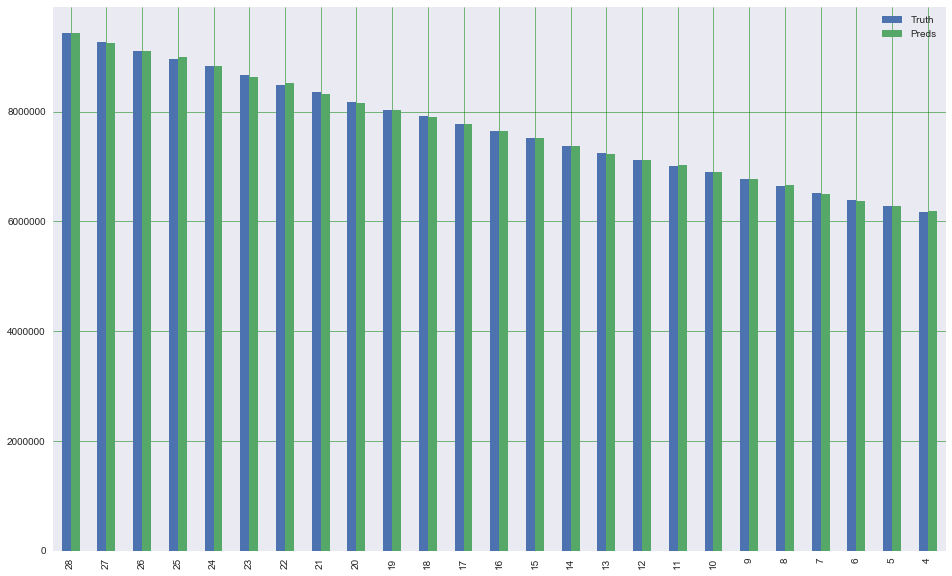

In [36]:
df1 = test_df.sort_values(by=['Truth', 'Preds'], ascending=False).head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [37]:
predictions

array([5.70433591e+06, 5.81033423e+06, 5.93227318e+06, ...,
       8.72371719e+00, 2.08174915e+01, 2.61142622e+01])

### Make predictions on country data

In [38]:
country_data = confirmed["Germany"]
country_data

1/22/20         0
1/23/20         0
1/24/20         0
1/25/20         0
1/26/20         0
            ...  
6/20/20    190670
6/21/20    191272
6/22/20    191768
6/23/20    192480
6/24/20    192871
Name: Germany, Length: 155, dtype: int64

In [39]:
country_test_x, country_test_y = create_dataset(country_data, 11)

In [40]:
country_predictions = lr_model.predict(country_test_x)

country_test_dic = {}
country_test_dic["Truth"] = country_test_y
country_test_dic['Preds'] = country_predictions
country_test_df = pd.DataFrame(country_test_dic)
len(country_test_df)

144

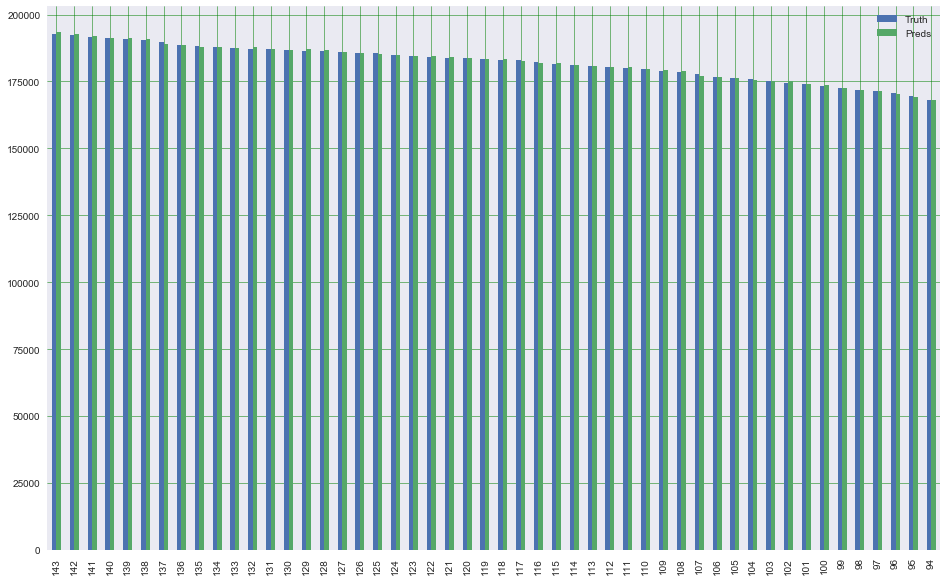

In [41]:
df_country = country_test_df.sort_values(by=['Truth', 'Preds'], ascending=False).head(50)
df_country.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()